In [ ]:
import sys, os
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './../')

import copy
import multiprocessing
import numpy as np
import glob
from numpy import array
from numpy.random import normal as gaussian
import pandas as pd
#import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, Model, models, optimizers
from tensorflow.python.ops import math_ops
from collections import CounterQualification
#from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from scipy.stats import gmean, ks_2samp
from sklearn.metrics import mutual_info_score, mean_squared_error as mse
from functions import *
#import math
import pandas as pd
#import shutil
from sklearn.preprocessing import normalize as norm



2024-11-24 03:00:16.163722: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 03:00:16.221625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


seed:  890737022


In [4]:
eBins  = ['e10_GeV','e20_GeV','e30_GeV','e40_GeV','e50_GeV','e60_GeV','e70_GeV','e80_GeV','e90_GeV','e100_GeV','e110_GeV','e120_GeV','e130_GeV','e140_GeV','e150_GeV','e160_GeV','e170_GeV','e180_GeV','e190_GeV','e200_GeV']
#eBins  = ['e110_GeV']
global idx3x3, idx5x5, ij_cell
idx5x5 = array(range(25))
idx3x3 = getIdxClus_mxn(idx5x5.reshape(5,5), 3, 3)
ij_cell = ['-2,2' , '-1,2' , '0,2' , '1,2' , '2,2' ,
           '-2,1' , '-1,1' , '0,1' , '1,1' , '2,1' ,
           '-2,0' , '-1,0' , '0,0' , '1,0' , '2,0' ,
           '-2,-1', '-1,-1', '0,-1', '1,-1', '2,-1',
           '-2,-2', '-1,-2', '0,-2', '1,-2', '2,-2',]

source   = '/eos/user/m/msandesd/Pesquisa/phd/crosstalk'                                              
output   = f'{source}/ml_trainings/pythonRuns/lzt/mlp'
emsData  = f'{source}/datasets/simulatedClusters/emshower'
mlpEMS   = f'{source}/ml_trainings/pythonRuns/emshower/mlp'

pathOut = createPath( f'{emsData}/plots' )

ext      = 'pdf'
scat_ext = 'png'

typeTrain = 'signal'

if typeTrain.lower()=='samples': Ebin = False
else: Ebin = True

"""
  Full Cluster  |  Hottest Cell  |   1st Neig   |   2nd Neigs     |
  -------------   --------------   ------------     -------------
  0  1  2  3  4 |                |              |  0  1  2  3  4  |
  5  6  7  8  9 |                |   6  7  8    |  5           9  |
 10 11 12 13 14 |       12       |   11    13   | 10          14  | 
 15 16 17 18 19 |                |   16 17 18   | 15          19  |
 20 21 22 23 24 |                |              | 20 21 22 23 24  |

"""
cells           = [0, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
secondNeighbors = [0, 1, 2,  3,  4,  5,  9, 10, 14, 15, 19, 20, 21, 22, 23, 24]
firstNeighbors  = [6, 7, 8, 11, 13, 16, 17, 18]

print(f'Load data and the first configuration is done!')

Load data and the first configuration is done!


In [5]:
#pathHistoData = f'{source}/histos'
#if not os.path.exists(f'{pathHistoData}'):
#    os.mkdir(f'{pathHistoData}')
    
fileEtruth     = f'{emsData}/Clusters_Etruth_745k.txt'
fileEtruthSamp = f'{emsData}/Clusters_EtruthSamp_745k.txt'
fileGsamples   = f'{emsData}/Clusters_CellsSignalSamples_745k.txt'
fileXTcAmplit  = f'{emsData}/Clusters_CellsXTcAmplitude_745k.txt'
fileXTlAmplit  = f'{emsData}/Clusters_CellsXTlAmplitude_745k.txt'
fileXTcSamples = f'{emsData}/Clusters_CellsXTcSignalSamples_745k.txt'
fileXTlSamples = f'{emsData}/Clusters_CellsXTlSignalSamples_745k.txt'
fileNoise      = f'{emsData}/Clusters_NoiseSamples_745k.txt'
fileTau0       = f'{emsData}/Clusters_Tau_0_745k.txt'
fileXTclsamp   = f'{emsData}/Clusters_XTclSamp_745k.txt'
fileNoisesamp  = f'{emsData}/Clusters_NoiseSamples_745k.txt'
fileEimpact    = f'{emsData}/Clusters_Eimpact_745k.txt'

### ================================================

## Optimal filter coefficients
ai = [0.3227028, 0.5390962, 0.3881769, 0.1247128]
bi = [-15.31452, -4.724544, 16.791813, 14.272150]

print(f'Load data and the first configuration is done!')

Load data and the first configuration is done!


In [6]:
from tensorflow.python.keras.layers import pooling

###################################
## Plot definitions
###################################

SMALL_SIZE  = 10
MEDIUM_SIZE = 16  # 15
LARGE_SIZE  = 18  # 14
STICK_SIZE  = 14  # 14
BIGGER_SIZE = 20  # 12
HUGE_SIZE   = 22
#plt.rcParams.update({
#  "text.usetex": True,
#  "font.family": "Palatino"
#})
### rcParams['font.family'] = 'sans-serif'
### rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
###                               'Lucida Grande', 'Verdana']
### font.family        : serif
### font.serif         : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
### font.sans-serif    : Helvetica, Avant Garde, Computer Modern Sans Serif
### font.cursive       : Zapf Chancery
### font.monospace     : Courier, Computer Modern Typewriter

### text.usetex        : true
###
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rc('font',   size      = HUGE_SIZE)  # controls default text sizes
plt.rc('axes',   titlesize = HUGE_SIZE)   # fontsize of the axes title
plt.rc('axes',   labelsize = HUGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize = STICK_SIZE)   # fontsize of the tick labels
plt.rc('ytick',  labelsize = STICK_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize  = BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title

In [7]:
Etruth       = array(pd.read_csv(fileEtruth,     delim_whitespace=True, header=None))
EtruthSamp   = array(pd.read_csv(fileEtruthSamp, delim_whitespace=True, header=None))
XTclSamp     = array(pd.read_csv(fileXTclsamp,   delim_whitespace=True, header=None))
NoiseSamp    = array(pd.read_csv(fileNoisesamp,  delim_whitespace=True, header=None))

In [8]:
XTcAmp       = array(pd.read_csv(fileXTcAmplit, delim_whitespace=True, header=None))
XTlAmp       = array(pd.read_csv(fileXTlAmplit, delim_whitespace=True, header=None))

In [9]:
def plot_heatmap(data, **kwargs):
    default_params = {
        "ext": "pdf",
        "fileName": "",
        "GeV": 1,
        "label": "",        
        "log": False,
        "pathOut": None,
        "precis": 2,
        "save": False,        
        "show": True,
        "titleName": "",
        "vMin": np.amin(data)*0.8,
        "vMax": np.amax(data)*1.5,
        "xy_labels": None
    }
    params = {**default_params, **kwargs}
    
    from matplotlib import cm, colors
    plt.rcParams["figure.figsize"] = (10,6)
    plt.rc('figure', titlesize=44)  # fontsize of the figure title
    #fig  = plt.figure()
    fig, ax   = plt.subplots()
    n       = int(np.sqrt(len(data)))
    data    = data.reshape(n,n)/params["GeV"]
    if params["log"] == False:
        heatmap = plt.pcolor(data, cmap=cm.YlOrBr, norm=colors.Normalize(vmin=params["vMin"], vmax=params["vMax"]))
    else :
        heatmap = plt.pcolor(data, cmap=cm.YlOrBr, norm=colors.LogNorm(vmin=params["vMin"], vmax=params["vMax"]))        
    xy_position = array(range(n))
    if params["xy_labels"] is None:
        xy_labels = xy_position
    else: 
        xy_labels = array(range(params["xy_labels"][0], params["xy_labels"][1]))

    for y in range(n):
        for x in range(n):
            plt.text(x + 0.5, y + 0.5, f'{data[y, x]:.{params["precis"]}f}',
                    horizontalalignment='center',
                    verticalalignment='center',
                     fontsize=12
                    )
    #plt.colorbar(heatmap, format=f'%.{precis}f')
    plt.colorbar(heatmap)
    ax.invert_yaxis()    
    plt.xticks( xy_position +0.5, xy_labels)
    plt.yticks( xy_position +0.5, xy_labels)
    plt.tick_params(axis='both', which='major', labelsize=STICK_SIZE, labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.title(f'{params["titleName"]}')

    if params["save"] == True:
        fig.savefig(f'{params["pathOut"]}/{params["fileName"]}.pdf', format='pdf')  

    if params["show"] == False :
        plt.close(fig)        
    elif params["show"] == True:
        #plt.show()
        #plt.gca().set_yscale("log")
        plt.show()          
    del fig  

In [10]:
def plotHisto(y1, **kwargs):
    """
    pathOut   - where you want to store the plot
    label     - is a list with 4 informations: 1st, 2nd, 3rd is the label for the signal, and the 4th is the legend position
    fileName  - File name to store
    titleName - Plot title
    show      - True sows the plot, False none
    log       - True ylog scale, False none
    ext       - File extension
    MeanRms:  
              - 'mean' to calculate mean and std values for each signal => mean +/- std
              - 'rms' to calculate the rms and rmse values for each signal => rms +/- rmse
    save      - True save plot on pathOut, false none
    y1        - first signal  (mlp)
    y2        - second signal (of)
    y3        - third signal (target)
    """    
    # Define default values for parameters
    default_params = {
        "axisFormat": False,        
        "adjustXlim": False,
        "cell_00": False,
        "colLegend": False,
        "color": False,
        "detail": False,
        "ext": "pdf",
        "fileName": "",
        "label": "",
        "legend": None,
        "log": False,
        "MeanRms": "mean",
        "nStd": None,
        "pathOut": "",
        "save": False,        
        "show": True,
        "titleName": "",
        "text": [],
        "unit": "",
        "xRange": None,        
        "y2": None,
        "y3": None,
        "ss": False,
        "ks": None
        }
    
    def custom_formatter(x, pos, scale_x):
        """
        Custom tick formatter for the x-axis.
        """
        if scale_x != 1:
            magnitude = len(str(int(x))) - 1  # Calculate the magnitude of the number
            decimals = max(0, 2 - magnitude)   # Determine the number of decimal places
            return f'{x * scale_x:.2f}'
        else:
            return f'{x:.2f}'
            
        # Update default parameters with provided keyword arguments
    params = {**default_params, **kwargs}

    if params["color"]:
        listColors = ['royalblue', 'sandybrown', 'gainsboro']
        listEdges  = ['navy', 'orangered', 'black']
        #listColors = ['khaki', 'purple', 'gainsboro']
        #listEdges  = ['darkorange', 'indigo', 'black']
    else:
        listColors = ['royalblue', 'indianred', 'gainsboro']
        listEdges  = ['navy', 'red', 'black']
        
    plt.rcParams["figure.figsize"] = (10,6)
    scale_x = 1    
    xscale  = 1        
    y2, y3 = params["y2"], params["y3"]

    if y2 is not None and y3 is not None:
        arrays = [y1, y2, y3]    
    elif y2 is not None:                
        arrays = [y1, y2]
    else:            
        arrays = [y1]
        
    if params["label"].lower() == 'energy':
        if rms( array( arrays ) ) < 0.01:
            arrays = list(10000*array(arrays))
            xLabel = r'Energy [$10^{-3}$'+f' {params["unit"]}]'
        else :
            xLabel = f'Energy [{params["unit"]}]'
    elif params["label"] == 'time':        
        xLabel = 'Time [ns]'
        unit   = 'ns'        
    elif params["label"] == 'ss':
            xscale = 1
            xLabel = params["label"]#label
            unit   = ''        
    else :
        if rms( array(arrays)) < 0.01:
            xscale  = 10000
            xLabel = f'{params["label"]} '+r'[$10^{-4}$]'            
        else: 
            xscale = 1
            xLabel = params["label"]#label
            unit   = ''                
    if params["ss"]:
        xscale = 100
        xLabel = f'{params["label"]} '+r'[$10^{-2}$]'   
        
    Nbins, Ndpi  = 100, 700
    if params["xRange"]:        
        minBin, maxBin = min(params["xRange"]), max(params["xRange"])
    else :
        minBin, maxBin = min_max( arrays )

    if params["adjustXlim"]:
        if params["cell_00"]: pass
        else:
            if params["nStd"] is None:
                nStd = 3
            else:
                nStd = params["nStd"]

            if np.min(arrays)>0 and not params["cell_00"]:
                nn = 3
            else: nn = 1
            
            minBin, maxBin = np.mean(arrays) - nStd/nn*np.std(arrays), np.mean(arrays) + nStd*np.std(arrays)
        #nBins = np.linspace(xmin, xmax, 100)
        
    ## To adjust time displayment to better visualization
    ## once the time expected is a zero mean distribution
    valueBins = np.linspace(minBin, maxBin, Nbins)
    
    ## ===========================
    ## ---------- Details --------    
    unit    = params["unit"]
    if params["detail"]:
        #arrays = [y1, y2, y3]       
        k_NN,  p_NN  = ks_2samp(arrays[0], arrays[1])        
        
        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 5]})
        plt.subplots_adjust(wspace=0.05) 
        maxStd = maxBin
        meanRmsResults = getMeanRms( arrays , MeanRms=params["MeanRms"])
        minBin, maxBin = min_max( arrays )
        valueBins = np.linspace(minBin, maxBin, Nbins)
        
        #print(meanRmsResults)
        
        ## Left plot: Zoomed in version
        for i, arr in enumerate(arrays):
            n_arr = len(arrays)
            label = params["legend"][i] #if params["legend"] and i < len(params["legend"]) #else f'Data {i+1}'
            color, edgecolor, alpha = ['royalblue', 'indianred', 'gainsboro'][i % n_arr], ['navy', 'red', 'black'][i % n_arr], [0.5, 0.5, 0.4][i % n_arr]
            ax[0].hist(arr, bins=valueBins, ec=edgecolor, alpha=alpha, fc=color, lw=1.2, histtype='stepfilled', label=f'{label}'.ljust(10, ' ') + f': {meanRmsResults[i][0]*xscale:.2f} $\pm$ {meanRmsResults[i][1]*xscale:.2f}'.rjust(22, ' '))
            
        xmin,xmax,ymin,ymax = ax[0].axis()
        ax[0].legend(frameon=False, loc='upper right')

        if params["log"]:
            ax[0].set_yscale('log')
            ax[0].set_ylim([10, 20*abs(ymax)])
        elif len(y1) >= 1e3:
            scale_y = 1e3
            ax[0].set_ylim([None, 1.4*ymax])
            ax[0].set_ylabel(f'Count'+r' [10$^3$]')    
            
            ticks_y = ticker.FuncFormatter(lambda y1, pos: '{0:g}'.format(y1/scale_y))
            ax[0].yaxis.set_major_formatter(ticks_y)
        else: ax[0].set_ylabel('Count')            

        if len(params["text"]) == 2:
            textstr = '\n'.join((
            f'{params["text"][0]}',
            f'{params["text"][1]}'))
            ax[0].text(0.05, 0.65, textstr, transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top')
        else:
            textstr = f'\n{params["text"][0]}'
            ax[0].text(0.05, 0.7, textstr, transform=ax[0].transAxes, fontsize=16,
            verticalalignment='top')   
            
        ax[0].set_xlabel(f'{xLabel}')         
        ax[0].grid(ls='--', lw=0.65)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        ## ==========================
        ## Right plot: Zoomed in version
        del params["legend"][1]
        del arrays[1]
        minBin, maxBin = min_max( arrays )
        valueBins = np.linspace(minBin, maxBin, Nbins)

        for i, arr in enumerate(arrays):
            label = params["legend"][i] #if params["legend"] and i < len( params["legend"] ) #else f'Data {i+1}'
            color, edgecolor, alpha = ['royalblue', 'gainsboro'][i % 2], ['navy', 'black'][i % 2], [0.6, 0.6][i % 2]
            ax[1].hist(arr, bins=valueBins, ec=edgecolor, alpha=alpha, fc=color, lw=1.3, histtype='stepfilled', label=label, )
                
        # Set zoomed-in x-axis limits if adjustXlim is set
        n, bins, _ = ax[1].hist(arrays[0], bins=valueBins, alpha=0)  # Just to get bin counts without drawing
        
        xmin,xmax,ymin,ymax = ax[1].axis()
       
        if params["adjustXlim"]:
            nn = np.where(n>10)
            if len(nn[0]) < 40:
                ii = list(n).index(np.max(n))
                if ii+5 > 99:
                    ax[1].set_xlim([bins[ii-5], bins[-1]])
                elif ii-5 < 0:
                    ax[1].set_xlim([bins[0], bins[ii+5]])
                else :
                    ax[1].set_xlim([bins[ii-5], bins[ii+5]])
        
        ax[1].legend(frameon=False, loc='upper right')
        #ax[1].yaxis.set_major_formatter(plt.NullFormatter())

        if params["log"]:
            ax[1].set_yscale('log')
            ax[1].set_ylim([10, 30*abs(ymax)])
        elif len(y1) >= 1e3:
            scale_y = 1e3
            ax[1].set_ylim([None, 1.4*ymax])
            ax[1].set_ylabel('')  # No ylabel
            # Add y-axis ticks on the right for ax[1]
            ax[1].yaxis.tick_right()  # Moves the y-axis ticks to the right
            ax[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)  # Enable right ticks, disable left ticks
            # Add ylabel on the right for ax[1]
            ax[1].yaxis.set_label_position('right')  # Move the ylabel to the right
            ax[1].set_ylabel(f'Count'+r' [10$^3$]') # Add ylabel text
            
            ticks_y = ticker.FuncFormatter(lambda y1, pos: '{0:g}'.format(y1/scale_y))
            ax[1].yaxis.set_major_formatter(ticks_y)
            
        else:            
            ax[1].set_ylim([None, 1.4*ymax])
            ax[1].set_ylabel('')  # No ylabel
            # Add y-axis ticks on the right for ax[1]
            ax[1].yaxis.tick_right()  # Moves the y-axis ticks to the right
            ax[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)  # Enable right ticks, disable left ticks
            # Add ylabel on the right for ax[1]
            ax[1].yaxis.set_label_position('right')  # Move the ylabel to the right
            ax[1].set_ylabel('Count')                        
        ax[1].set_xlim([ np.mean(arrays) - 3*np.std(arrays), np.mean(arrays) + 3*np.std(arrays) ])            
        ax[1].grid(ls='--', lw=0.7)
        ax[1].set_xlabel(f'{xLabel}') 
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)        

                # Join all items with line breaks
        textstr = f"KS: {params['ks']:.3f}"

        # Add the text to the plot
        ax[1].text(0.05, 0.75, textstr, transform=ax[1].transAxes, fontsize=18,
                verticalalignment='top') 
    ## ===========================
    ## ---- Whithout Details -----
    else :        
        meanRmsResults = getMeanRms(arrays, MeanRms=params["MeanRms"])
        fig    = plt.figure()
        ax     = fig.add_subplot(111)
        MeanRms = params["MeanRms"]
        titleName = params["titleName"]
        
        for i, arr in enumerate(arrays):
            n_arr = len(arrays)
            label = params["legend"][i] #if params["legend"] and i < len(params["legend"]) #else f'Data {i+1}'
            #color, edgecolor, alpha = ['royalblue', 'indianred', 'gainsboro'][i % n_arr], ['navy', 'red', 'black'][i % n_arr], [0.6, 0.5, 0.5][i % n_arr]
            color, edgecolor, alpha = listColors[i % n_arr], listEdges[i % n_arr], [0.6, 0.5, 0.5][i % n_arr]
            ax.hist(arr, bins=valueBins, ec=edgecolor, alpha=alpha, fc=color, lw=1.2, histtype='stepfilled', label=f'{label}'.ljust(10, ' ') + f': {meanRmsResults[i][0]*xscale:.2f} $\pm$ {meanRmsResults[i][1]*xscale:.2f}'.rjust(22, ' '))

        n, bins, _ = ax.hist(arrays[0], bins=valueBins, alpha=0)  # Just to get bin counts without drawing
        
        ax.set_title( params["titleName"])
        ax.set_xlabel(f'{xLabel}')
        ax.grid(linestyle='--',linewidth=.7)
        ax.legend(frameon=False, loc=1)

        xmin,xmax,ymin,ymax = ax.axis()        
        if params["log"]:
            plt.gca().set_yscale("log")
            ymax = max(set(n))
            ax.set_ylim([10, 40*abs(ymax)])
            ax.set_ylabel(f'Count')#+r' [10$^3$]')        
            scale_y = 1e3
            fileName = f'{params["fileName"]}_log'
        elif len(y1) > 5e3:
            scale_y = 1e3
            ax.set_ylim([None, 1.5*ymax])
            ax.set_ylabel(f'Count'+r' [10$^3$]')
        else :
            scale_y = 1
            ax.set_ylim([None, 1.5*ymax])
            ax.set_ylabel(f'Count')
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ticks_y = ticker.FuncFormatter(lambda y1, pos: '{0:g}'.format(y1/scale_y))
        ax.yaxis.set_major_formatter(ticks_y)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: custom_formatter(x, pos, xscale)))
    if not params["detail"]:
        
        # Insert an extra space after the first item
        #if len(params["text"]) > 1:
            #params["text"].insert(1, '')  # Adds an extra blank line after the first item
        # Join all items with line breaks
        textstr = '\n'.join(params["text"])
        if params["ks"] is not None:
            textstr += f"\nKS: {params['ks']:.3f}"
        # Add the text to the plot
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
                verticalalignment='top')  

    if params["save"]:
        fig.savefig(f'{params["pathOut"]}/{params["fileName"]}.{params["ext"]}', format='pdf', dpi=Ndpi)    

    if not params["show"]:
        plt.close(fig)
        plt.close()
    elif params["show"]:
        plt.show()
    del fig     


In [11]:
def getMeanRms(x1, MeanRms='mean'):    

    # Determine whether to calculate 'mean' or 'rms'
    if MeanRms.lower() == 'mean':
        means = np.mean(x1, axis=1)  # Calculate mean for each column
        stds = np.std(x1, axis=1)    # Calculate std for each column
        stds = np.maximum(np.round(np.std(x1, axis=1), 2), 0.01) 
        
    elif MeanRms.lower() == 'rms':
        means = rms(x1, axis=1)      # Calculate rms for each column
        stds = np.std(x1, axis=1)    # Calculate std for each column
        stds = np.maximum(np.round(np.std(x1, axis=1), 2), 0.01)    # Calculate std for each column
        
        
    else:
        raise ValueError("MeanRms should be either 'mean' or 'rms'.")

    # Intercalate means and stds dynamically
    results = []
    for mean, std in zip(means, stds):
        results.append([mean, std])
        #results.append(std)

    return results


In [12]:
## Optinal Filtering (Baseline)
def OptFilt(samples, ai=None, bi=None):
    idx_7x7 = array(range(49))
    idx_5x5 = getIdxClus_mxn(idx_7x7.reshape(7,7), 5, 5)
    idx_3x3 = getIdxClus_mxn(idx_7x7.reshape(7,7), 3, 3)
    ij_cell = ['-3,3' , '-2,3' , '-1,3' , '0,3' , '1,3' , '2,3' , '3,3' , 
           '-3,2' , '-2,2' , '-1,2' , '0,2' , '1,2' , '2,2' , '3,2' , 
           '-3,1' , '-2,1' , '-1,1' , '0,1' , '1,1' , '2,1' , '3,1' , 
           '-3,0' , '-2,0' , '-1,0' , '0,0' , '1,0' , '2,0' , '3,0' , 
           '-3,-1', '-2,-1', '-1,-1', '0,-1', '1,-1', '2,-1', '3,-1', 
           '-3,-2', '-2,-2', '-1,-2', '0,-2', '1,-2', '2,-2', '3,-2', 
           '-3,-3', '-2,-3', '-1,-3', '0,-3', '1,-3', '2,-3', '3,-3' ]
    if samples.shape[1] == 25 : ij_cell = ij_cell[idx_5x5]
    if samples.shape[1] == 9 : ij_cell = ij_cell[idx_3x3]
    if ai is None:        
        ##produces a tau_0 = -0.89
        #ai = [  0.36308142, 0.47002328, 0.39304565,  0.30191008]
        #bi = [-20.77449385, 5.48756441, 6.21710107, 10.33539619]

        ## Mykola coeffs
        ## produces a tau_0 = 0.04 on LZT data
        ai = [0.3594009, 0.49297974, 0.38133506, 0.24622458]
        bi = [-18.92073871, 0.90162148, 14.33011022, 6.34564695]

        ## the same result for Mikola coeffs
        #ai = [0.3227028, 0.5390962, 0.3881769, 0.1247128]
        #bi = [-15.31452, -4.724544, 16.791813, 14.272150]
        
    nSamp = len(ai)
    signals = int(samples.shape[1]/nSamp)
    AmpTime = dict()          
    
    AmpRec  = np.tensordot(samples.reshape(samples.shape[0], signals, nSamp),ai, axes=(2,0))    
    TimeRec = (np.tensordot(samples.reshape(samples.shape[0], signals, nSamp), bi, axes=(2,0)))/AmpRec

    AmpTime = {'Cells': { f'Cell {ij_cell[i]}':{'Amplitude':AmpRec[:,i], 'StdAmp':np.std(AmpRec[:,i]), 'Time': TimeRec[:,i], 'StdTime':np.std(TimeRec[:,i])} for i in range(signals)}}
    
    AmpTime.update({'Clusters': {'Std': {'Amp': np.sum(AmpRec, axis=0).std(), 'Time':TimeRec.mean(axis=0).std()}, 
                                 'Mean':{ 'Time':TimeRec.mean(axis=0),'Amp': AmpRec.mean(axis=0)},
                                 'SumAmplitudes':AmpRec.sum(axis=1), 'Amplitude':AmpRec,'Time':TimeRec, 'RawData': samples}})
    return AmpTime


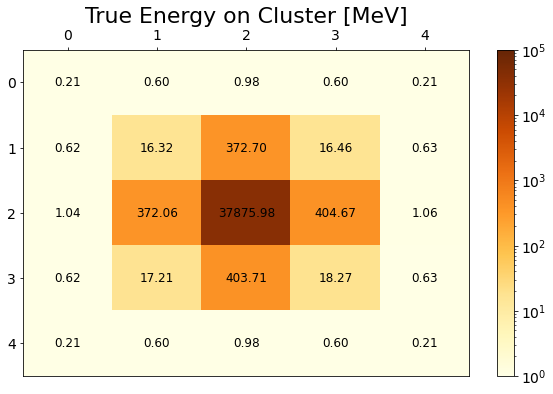

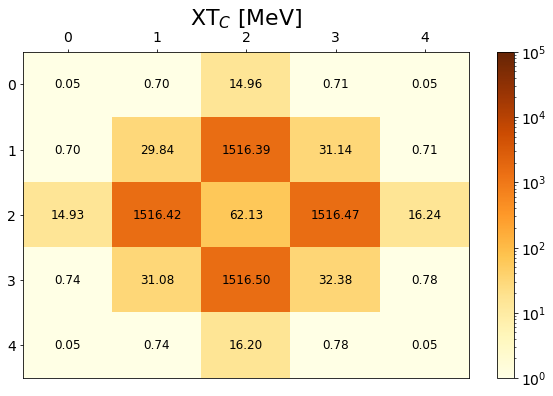

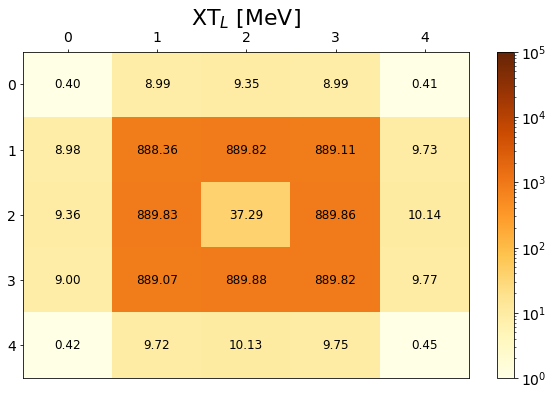

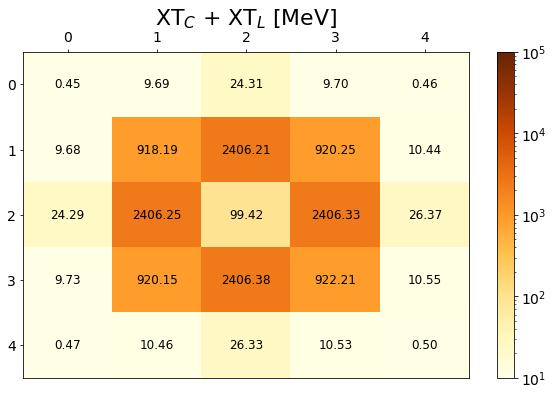

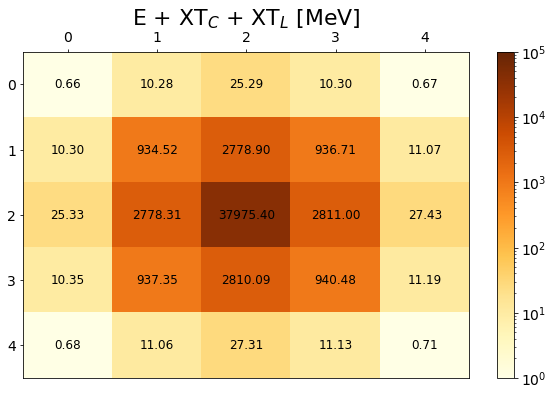

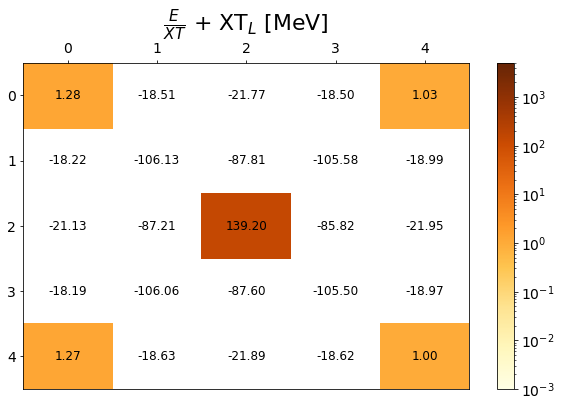

In [30]:
### (pathOut, data, title, fileName, show=False, precis=2)
ext = 'pdf'
vMin = 1
vMax = 1e5
histos = pathOut
save = True

title = f'True Energy on Cluster [MeV]'
fileName = f'Cluster5x5_EnergyTrue'
plot_heatmap(Etruth.mean(axis=0), pathOut=histos, titleName=title, fileName=fileName, show=True, save=save, vMin=vMin, vMax=vMax, log=True)

title = f'XT${{_C}}$ [MeV]'
fileName = f'Cluster5x5_XTc'
plot_heatmap(XTcAmp.mean(axis=0), pathOut=histos, titleName=title, fileName=fileName, show=True, save=save, vMin=vMin, vMax=vMax, log=True)

title = f'XT${{_L}}$ [MeV]'
fileName = f'Cluster5x5_XTl'
plot_heatmap(XTlAmp.mean(axis=0), pathOut=histos, titleName=title, fileName=fileName, show=True, save=save, vMin=vMin, vMax=vMax, log=True)

title = f'XT${{_C}}$ + XT${{_L}}$ [MeV]'
fileName = f'Cluster5x5_XTcl'
plot_heatmap((XTcAmp+XTlAmp).mean(axis=0), pathOut=histos, titleName=title, fileName=fileName, show=True, save=save, vMin=10, vMax=vMax, log=True)

title = f'E + XT${{_C}}$ + XT${{_L}}$ [MeV]'
fileName = f'Cluster5x5_EXTc'
plot_heatmap((Etruth + XTcAmp+XTlAmp).mean(axis=0), pathOut=histos, titleName=title, fileName=fileName, show=True, save=save, vMin=vMin, vMax=vMax, log=True)

title = r'$\frac{E}{XT}$ + XT${{_L}}$ [MeV]'
fileName = f'Cluster5x5_Ratio_EoverXTcl'
plot_heatmap(20*np.log(Etruth/(XTcAmp+XTlAmp)).mean(axis=0), pathOut=histos, titleName=title, fileName=fileName,  show=True, save=save, vMin=0.001, vMax=5e3, log=True)

## Plot histos

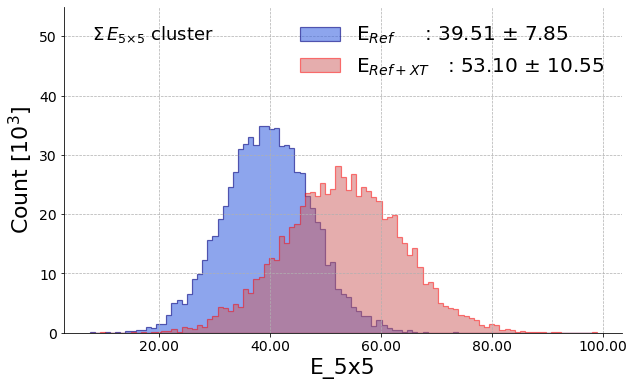

In [31]:
fileName = 'Energy_XT_Cluster_5x5'
label  = f'E_5x5'
legend = [f'E$_{{Ref}}$', f'E$_{{Ref+XT}}$']
text = [r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = True

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

plotHisto(E_2GeV.sum(axis=1), y2=(E_2GeV+ xtcl_2GeV).sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show)

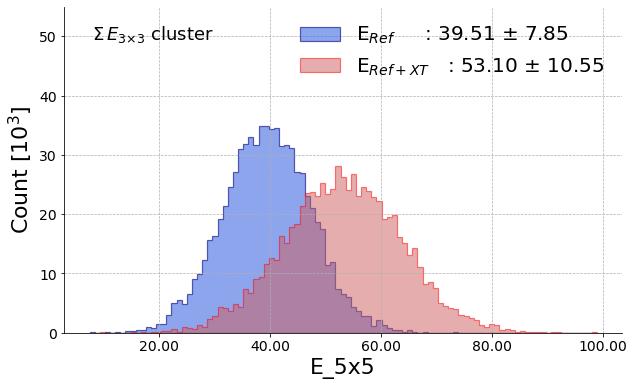

In [32]:
fileName = 'Energy_XT_Cluster_3x3'
label  = f'E_5x5'
legend = [f'E$_{{Ref}}$', f'E$_{{Ref+XT}}$']
text = [r'$\Sigma\, E_{3{\times} 3}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = True

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

plotHisto(E_2GeV.sum(axis=1), y2=(E_2GeV+ xtcl_2GeV).sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show)

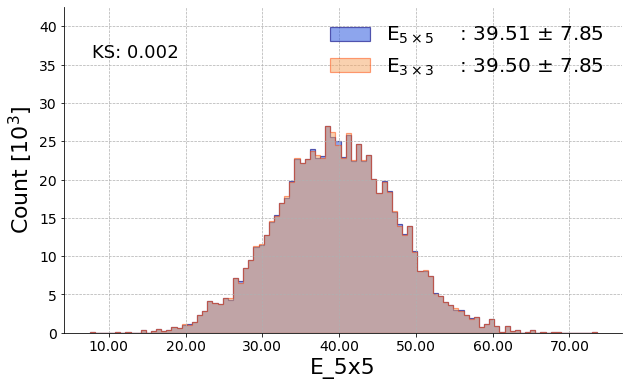

In [43]:
fileName = 'Energy_Cluster_3x3_5x5'
label  = f'E_5x5'
legend = [r'E$_{{5\times 5}}$', r'E$_{{3\times 3}}$']
text = ""#[r'$\Sigma\, E_{5{\times} 5} \times \Sigma\, E_{3{\times} 3}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = True

E_2GeV = Etruth/1000

KS, _ = ks_2samp( E_2GeV.sum(axis=1), E_2GeV[:,idx3x3].sum(axis=1) )

plotHisto( E_2GeV.sum(axis=1), y2= E_2GeV[:,idx3x3].sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show, ks=KS, color=True)

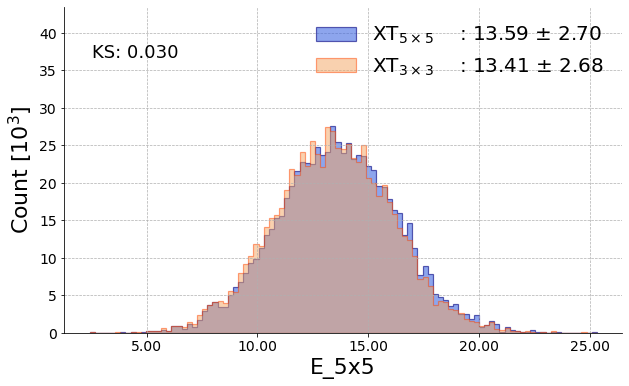

In [34]:
fileName = 'XT_Cluster_3x3_5x5'
label  = f'E_5x5'
legend = [r'XT$_{{5\times 5}}$', r'XT$_{{3\times 3}}$']
text = ""#[r'$\Sigma\, E_{5{\times} 5} \times \Sigma\, E_{3{\times} 3}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = True

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

KS, _ = ks_2samp( xtcl_2GeV.sum(axis=1), xtcl_2GeV[:,idx3x3].sum(axis=1) )

plotHisto( xtcl_2GeV.sum(axis=1), y2= xtcl_2GeV[:,idx3x3].sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show, ks=KS, color=True)

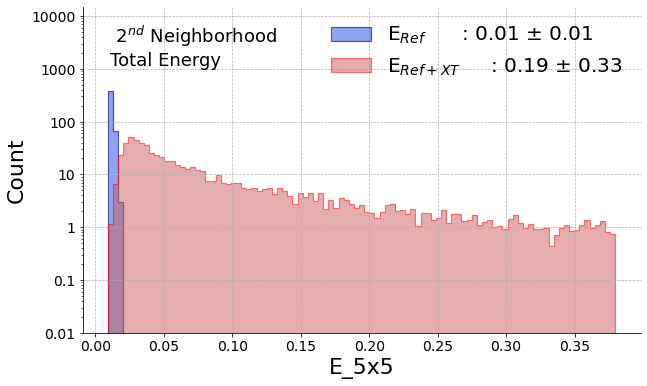

In [45]:
fileName = 'Energy_Cluster_2ndNeighborhood'
label  = f'E_5x5'
legend = [f'E$_{{Ref}}$', f'E$_{{Ref+XT}}$']
text = [' 2$^{nd}$ Neighborhood', 'Total Energy' ]#, r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = True

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

plotHisto( E_2GeV[:, secondNeighbors].sum(axis=1), y2= (E_2GeV+xtcl_2GeV)[:,secondNeighbors].sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show, adjustXlim=True, nStd=1.1, log=True)
#plotHisto(E_2GeV[:,secondNeighbors].sum(axis=1), y2=((E_2GeV + xtcl_2GeV)[:,secondNeighbors].sum(axis=1) , pathOut=pathOut, label=label, legend=legend, text=text, fileName=fileName, save=save, show=show, adjustXlim=True, nStd=1.2, log=True)

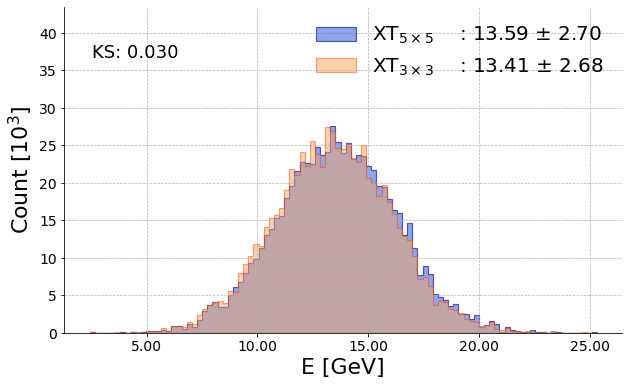

In [36]:
fileName = 'XT_Cluster_3x3_5x5'
label  = f'E_5x5'
legend = [r'XT$_{{5\times 5}}$', r'XT$_{{3\times 3}}$']
text = ""#[r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = False

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

KS, _ = ks_2samp( xtcl_2GeV.sum(axis=1), xtcl_2GeV[:, idx3x3].sum(axis=1) )

plotHisto(xtcl_2GeV.sum(axis=1), y2=xtcl_2GeV[:,idx3x3].sum(axis=1) , pathOut='path', label=f'E [GeV]', legend=legend, text=text, fileName=fileName, save=save, show=show, ks=KS, color=True)#, adjustXlim=True, nStd=1.2, log=True)

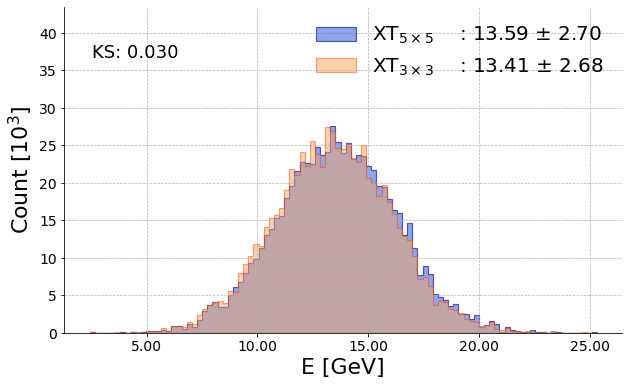

In [37]:
fileName = 'XT_Cluster_2ndNeighborhood'
label  = f'E_5x5'
legend = [r'XT$_{{5\times 5}}$', r'XT$_{{3\times 3}}$']
text = ""#[r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = False

E_2GeV = Etruth/1000
xtcl_2GeV = (XTcAmp+XTlAmp)/1000

KS, _ = ks_2samp( xtcl_2GeV.sum(axis=1), xtcl_2GeV[:, idx3x3].sum(axis=1) )

plotHisto(xtcl_2GeV.sum(axis=1), y2=xtcl_2GeV[:,idx3x3].sum(axis=1) , pathOut='path', label=f'E [GeV]', legend=legend, text=text, fileName=fileName, save=save, show=show, ks=KS, color=True)#, adjustXlim=True, nStd=1.2, log=True)

---

## Estimation wiht and without XT

In [38]:
EandT   = OptFilt(EtruthSamp)['Clusters']
EandTwT = OptFilt(EtruthSamp+ XTclSamp + NoiseSamp)['Clusters']

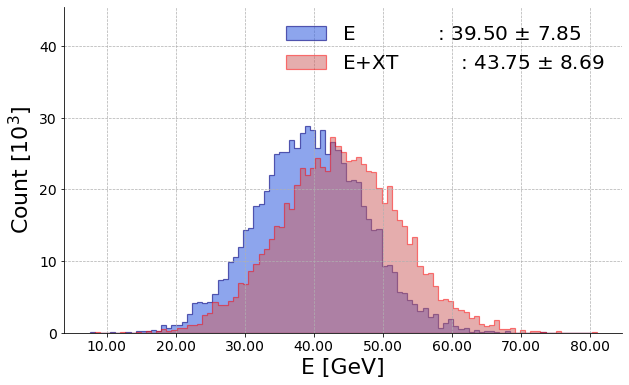

In [39]:
fileName = 'Energy_no_NN'
label  = f'E_5x5'
legend = [r'E', r'E+XT']
text = ""#[r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = False

EnoXT = EandT['Amplitude']/1000
EwXT  = EandTwT['Amplitude']/1000

KS, _ = ks_2samp( xtcl_2GeV.sum(axis=1), xtcl_2GeV[:, idx3x3].sum(axis=1) )

plotHisto(EnoXT.sum(axis=1), y2=EwXT.sum(axis=1), pathOut='path', label=f'E [GeV]', legend=legend, text=text, fileName=fileName, save=save, show=show)

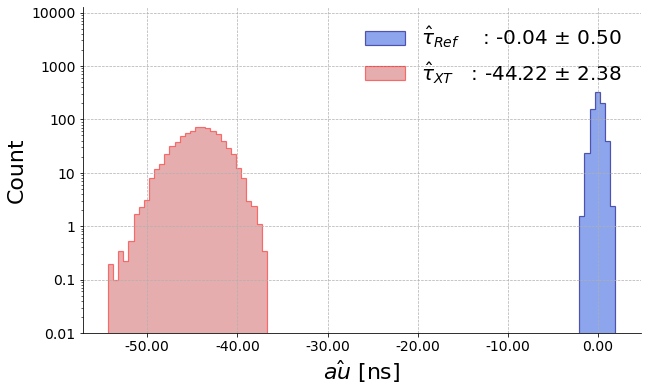

In [40]:
fileName = 'Time_no_NN'
label  = f'E_5x5'
legend = [r'$\hat{\tau}_{Ref}$', r'$\hat{\tau}_{XT}$']
text = ""#[r'$\Sigma\, E_{5{\times} 5}$ cluster']#, r'$\Sigma 5{\times} 5$ clus']
show = True
save = False

TnoXT = EandT['Time']
TwXT  = EandTwT['Time']

KS, _ = ks_2samp( xtcl_2GeV.sum(axis=1), xtcl_2GeV[:, idx3x3].sum(axis=1) )

plotHisto(TnoXT.mean(axis=1), y2=TwXT.mean(axis=1), pathOut='path', label=f'$\hat{{\tau}}$ [ns]', legend=legend, text=text, fileName=fileName, save=save, show=show, log=True)

## Plot and store for center cluster

In [42]:
show = False
save = True

for cell in idx3x3:
    if ij_cell[cell] == '0,0':
        cell_00 = True
    else: cell_00 = False        
        
    fileName = f'emshower_E_no_NN_cell_{ij_cell[cell]}'
    label  = f'E_5x5'
    legend = [r'$\hat{E}_{Ref}$', r'$\hat{E}_{XT}$']     
    
    KS, _ = ks_2samp( EnoXT[:,cell], EwXT[:, cell] )
    text   = [f"Cell: {ij_cell[cell]}", f"KS: {KS:.3f}"]
    
    plotHisto(EnoXT[:,cell], y2=EwXT[:, cell], pathOut=pathOut, label=f'E [GeV]', legend=legend, text=text, fileName=fileName, save=save, show=show, adjustXlim=True, nStd=2, cell_00=cell_00, log=True)

    KS, _ = ks_2samp( TnoXT[:,cell], TwXT[:, cell] )
    
    text   = [f"Cell: {ij_cell[cell]}", f"KS: {KS:.3f}"]
    fileName = f'emshower_T_no_NN_cell_{ij_cell[cell]}'
    label  = f'E_5x5'
    legend = [r'$\hat{\tau}_{Ref}$', r'$\hat{\tau}_{XT}$']
        
    plotHisto(TnoXT[:, cell], y2=TwXT[:, cell], pathOut=pathOut, label=r'$\hat{\tau}$ [ns]', legend=legend, text=text, fileName=fileName, save=save, show=show, log=True)

In [ ]:
g = array([cellFunction(i) for i in range(600)])
xtc = array([XTalk(i) for i in range(600)])
xtl = array([XTalk(i) for i in range(600)])
#samplingTime = np.arange(22, len(g), 25)
samplingTime = np.arange(22, 600, 25)
gSamples = g[samplingTime]
idx      = array(range(600))[samplingTime]
xtcSamples = xtc[samplingTime]
xtlSamples = xtl[samplingTime]
noise = genNoise(600, True)*0.1

compose = g + xtc*0.042 + xtl*0.02 + noise*0.08

compSamples = compose[samplingTime]

## Signals

In [ ]:
plt.plot( g, lw=2, label='Cell pulse')
plt.plot( xtc*0.4, label='XTc (x10)' )
plt.plot( xtl*0.2, label=('XTl (x20)') )
plt.plot( noise*.25, label='Noise')
plt.plot( compose , label='Total Signal\nShape')
xmin,xmax,ymin,ymax = plt.axis()
plt.ylim([None, 1.3*ymax])
plt.legend(frameon=False, ncols=2)
plt.grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
plt.xlabel('ns')
plt.ylabel('Amp. norm.')
#plt.scatter(idx, xtcSamples, color='k')
#plt.scatter(idx, xtlSamples, color='k')
plt.show()

## XT peak-peak, and under-peak definition

In [ ]:
x       = array(range(600)) 
xtAmp   = 0.45
compose = g + xtc*0.042 + xtl*0.02 + noise*0.08
maxIdxG = np.argmax(g)
maxIdxXT = np.argmax(xtc)
maxIdxComp = np.argmax(compose)

xMax_xt = x[maxIdxXT]
maxXT   = xtc[maxIdxXT]*xtAmp
xMax_g  = x[maxIdxG]
maxG    = g[maxIdxG]
xMax_comp  = x[maxIdxComp]
maxComp    = compose[maxIdxComp]

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 8]})
plt.subplots_adjust(wspace=0.15)
ax[0].plot( g, lw=2,   color='k', ls='--', label='Cell pulse', alpha=0.5)
ax[0].plot( xtc*xtAmp, color='r', label='XTc (x10)' )
ax[0].plot( compose,   color='royalblue', label='Total Signal\nShape')
#ax[0].scatter(idx, gSamples, color='k')
xmin,xmax,ymin,ymax = plt.axis()
#ax[0].set_ylim([None, 1.3*ymax])
ax[0].legend(frameon=False, ncols=1)
ax[0].grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
ax[0].set_xlabel('ns')
ax[0].set_ylabel('Amp. norm.')


ax[1].plot( g, lw=2,   color='gray', ls='--', label='g(t)')
ax[1].plot( xtc*xtAmp, color='r',  label='XTc (x10)' )
ax[1].plot( compose,   color='royalblue',  label='Compose')
ax[1].plot( array(range(500))*0, color='gray')
ax[1].vlines(x=xMax_g, ymin=0, ymax=maxG, color='k', linestyle='--' )
ax[1].scatter(xMax_g, maxG, color='k', s=50, label='Max Point')
ax[1].vlines(x=xMax_xt, ymin=0, ymax=maxXT, color='r', linestyle='--' )
ax[1].scatter(xMax_xt, maxXT, color='r', s=50 )
ax[1].scatter(xMax_g, xtc[maxIdxG]*xtAmp, color='k', s=100 )
ax[1].scatter(xMax_comp, maxComp, color='b', s=50 )
ax[1].vlines(x=xMax_comp, ymin=0, ymax=maxComp, color='b', linestyle='--' )
xmin,xmax,ymin,ymax = plt.axis()
ax[1].set_ylim([0, None])
ax[1].set_xlim([27, 53])
#ax[1].annotate(f'({xMax_xt:.2f}, {maxXT:.2f})', 
ax[1].annotate(f'V$_{{max}}$', 
             xy=(xMax_g, maxG), 
             #xytext=(xMax_xt + 0.5, maxXT + 0.5),
               xytext=(xMax_g -47, maxG - 50),
             textcoords='offset points', 
             arrowprops=dict(facecolor='k', alpha=0.5, shrink=0.05),
             fontsize=18)
ax[1].annotate(f'X$_{{max}}$', 
             xy=(xMax_xt, maxXT), 
             #xytext=(xMax_xt + 0.5, maxXT + 0.5),
               xytext=(xMax_xt -32, maxXT + 30),
             textcoords='offset points', 
             arrowprops=dict(facecolor='r', alpha=0.5, shrink=0.05),
             fontsize=18)
ax[1].annotate(f'X(T$_{{max}})$', 
             xy=(xMax_g, xtc[maxIdxG]*xtAmp), 
             xytext=(xMax_g -160, xtc[maxIdxG]*xtAmp - 16 ),
             textcoords='offset points', 
             arrowprops=dict(facecolor='gray', alpha=0.7, shrink=0.05),
             fontsize=18)
ax[1].annotate(f'New peak', 
             xy=(xMax_comp, maxComp), 
             xytext=(xMax_comp -180, maxComp - 5 ),
             textcoords='offset points', 
             arrowprops=dict(facecolor='b', alpha=0.7, shrink=0.05),
             fontsize=18)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

#ax[1].legend(frameon=False, ncols=1)
ax[1].grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
ax[1].set_xlabel('ns')
plt.savefig('XTdefinitions.pdf', format='pdf')
plt.show()
del fig

In [ ]:
xMax_g, maxG, xMax_comp

## Signal without zoom

In [ ]:
ax[0].plot( xtc*xtAmp, color='r', label='XTc (x10)' )

In [ ]:
x       = array(range(600)) 
xtAmp   = 0.45
compose = g + xtc*0.042 + xtl*0.02 + noise*0.2
maxIdxG = np.argmax(g)
maxIdxXT = np.argmax(xtc)
maxIdxComp = np.argmax(compose)

xMax_xt = x[maxIdxXT]
maxXT   = xtc[maxIdxXT]*xtAmp
xMax_g  = x[maxIdxG]
maxG    = g[maxIdxG]
xMax_comp  = x[maxIdxComp]
maxComp    = compose[maxIdxComp]

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 12]})
plt.subplots_adjust(wspace=0.15)
ax[0].plot( g, lw=2,   color='k', ls='--', label='g(t)', alpha=0.5)
ax[0].plot( xtc*xtAmp, color='g', label='XTc (x10)' )
ax[0].plot( xtc*0.2, color='orange', label='XTl (x10)' )
ax[0].plot( noise*0.2, color='lightcoral', label='Noise' )
ax[0].plot( compose,   color='royalblue', label='Total\nSignal\nShape')
ax[0].scatter(idx, compSamples, color='k')
xmin,xmax,ymin,ymax = plt.axis()
#ax[0].set_ylim([None, 1.3*ymax])
ax[0].legend(frameon=False, ncols=1, fontsize=14)
ax[0].grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
ax[0].set_xlabel('ns')
ax[0].set_ylabel('Amp. norm.')


ax[1].plot( g, lw=2,   color='k', ls='--', label='g(t)', alpha=0.5)
ax[1].plot( xtc*xtAmp, color='g', label='XTc (x10)' )
ax[1].plot( xtc*0.2, color='orange', label='XTl (x10)' )
ax[1].plot( noise*0.2, color='lightcoral', label='Noise' )
ax[1].scatter(idx, compSamples, color='k')
ax[1].plot( compose,   color='royalblue', label='Total\nSignal\nShape')
xmin,xmax,ymin,ymax = plt.axis()
#ax[0].set_ylim([None, 1.3*ymax])
ax[1].legend(frameon=False, ncols=1, fontsize=14)
ax[1].grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
ax[1].set_xlabel('ns')
#ax[1].set_ylabel('Amp. norm.')
ax[1].set_xlim([20, 130])
#ax[1].annotate(f'({xMax_xt:.2f}, {maxXT:.2f})', 

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

#ax[1].legend(frameon=False, ncols=1)
ax[1].grid(linestyle='--',linewidth=.7)
#plt.scatter(idx, gSamples, color='k')
ax[1].set_xlabel('ns')
plt.savefig('XTdefinitions.pdf', format='pdf')
plt.show()
del fig

## LAr Pulse

In [ ]:
tile = np.loadtxt('pulseTile.dat')
N = 600
samplTime = np.arange(-3, N, 25)
Gsamp = g[samplTime]
idxG  = array(range(N))[samplTime]

In [ ]:
fig = plt.figure() 
plt.plot(g, label='Cell pulse')
plt.scatter(idxG, Gsamp, color='k', label='Sampling Time')
plt.xlabel('ns')
plt.ylabel('Amp. norm')
plt.legend(frameon=False)
plt.grid(linestyle='--',linewidth=.7)
plt.show()
plt.savefig('pulseLAr.pdf', format='pdf')
del fig

## Tile Pulse

In [ ]:
tile = np.loadtxt('pulseTile.dat')
N = 400
samplTime = np.arange(0, N, 25)
TileSamp = tile[:,1][samplTime]
idxTile  = array(range(N))[samplTime]

In [ ]:
fig = plt.figure() 
plt.plot(tile[:,1], label='Cell pulse')
plt.scatter(idxTile, TileSamp, color='k', label='Sampling Time')
plt.xlabel('ns')
plt.ylabel('Amp. norm')
plt.legend(frameon=False)
plt.grid(linestyle='--',linewidth=.7)
plt.show()
plt.savefig('pulseTile.pdf', format='pdf')
del fig

In [ ]:
N = 75
I = 0
g = array([cellFunction(i) for i in range(600)])
samplingTime = np.arange(22, N, 25)
gSamples = g[samplingTime]
x        = array(range(600))
idx      = array(range(600))[samplingTime]

# Find the index of the maximum value in y
maxIdxG = np.argmax(g[I:N])
maxIdxXT = np.argmax(xtc[I:N])
maxIdxComp = np.argmax(compose[I:N])

# Find the corresponding x value
xMax_xt = x[maxIdxXT]
maxXT   = xtc[maxIdxXT]*0.4
xMax_g  = x[maxIdxG]
maxG    = g[maxIdxG]

xMax_comp  = x[maxIdxComp]
maxComp    = compose[maxIdxComp]

plt.plot( g[I:N], lw=2, color='k', alpha=0.5, label='Cell Pulse')
plt.plot( xtc[I:N]*0.45, color='r', label='XTC' )
#plt.plot( xtl[I:N]*0.2 )
#plt.plot( noise[I:N]*.1)
plt.plot( compose[I:N], color='b', label='Compose' )
plt.plot( array(range(N))*0, color='gray')
plt.grid(linestyle='--',linewidth=.7)
plt.scatter(idx, gSamples, color='k')
xmin,xmax,ymin,ymax = plt.axis()
plt.ylim([None, 1.5*ymax])
plt.vlines(x=xMax_g, ymin=0, ymax=maxG, color='k', linestyle='--', label=f'Max at x={xMax_g:.2f}')
plt.vlines(x=xMax_xt, ymin=0, ymax=maxXT, color='red', linestyle='--', label=f'Max at x={xMax_xt:.2f}')
plt.vlines(x=xMax_comp, ymin=0, ymax=maxComp, color='b', linestyle='--', label=f'Max at x={xMax_xt:.2f}')
plt.xlim([20, N])
plt.legend(frameon=False, ncol=2, loc=1)

#plt.scatter(idx, xtcSamples, color='k')
#plt.scatter(idx, xtlSamples, color='k')
plt.show()

In [ ]:
maxIdxComp

In [ ]:
# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x) + 0.5 * x

# Find the index of the maximum value in y
max_index = np.argmax(y)

# Find the corresponding x and y values
max_x = x[max_index]
max_y = y[max_index]

plt.plot(x, y, label='y = sin(x) + 0.5x')

plt.vlines(x=max_x, ymin=0, ymax=max_y, color='red', linestyle='--', label=f'Max at x={max_x:.2f}')

plt.scatter([max_x], [max_y], color='red')  # Highlight the max point
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot with Vertical Line to Peak')
plt.show()